In [ ]:
# %pip install umap matplotlib imblearn dask xgboost dask[distributed]
# %restart_python 
%pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 67.2 MB/s eta 0:00:00
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [ ]:
import pandas as pd
import numpy as np
from pyspark.sql.functions import col, sum as _sum
from pyspark.sql.types import *
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
from seaborn import color_palette
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [ ]:
## Get data 
df = spark.sql('''
               select * from big_data_ii_2025.default.iot_malware_capture_1
               ''')

## Columns should be renamed so that there will be no error regarding feature names
df = df.withColumnsRenamed({"id.orig_h": "id_orig_h",
                      "id.orig_p": "id_orig_p",
                      "id.resp_h": "id_resp_h",
                      "id.resp_p": "id_resp_p"})

## Consolidate labels into 'Malicious' and 'Benign'
from pyspark.sql.functions import when, lit
df = df.withColumn("label", 
                   when(df["label"].contains("Malicious"), lit("Malicious"))
                   .otherwise(lit("Benign")))

In [ ]:
## Check top 5 most common values in each column to detect nulls or no relevant values
for col in df.columns:
    df.groupBy(col).count().show(5)
    print("-"*100)


+-------------------+-----+
|                 ts|count|
+-------------------+-----+
|1.525879982025612E9|    1|
|1.525880115046185E9|    1|
|1.525880166017923E9|    1|
|1.525880757049002E9|    1|
|1.525881107017171E9|    1|
+-------------------+-----+
only showing top 5 rows
----------------------------------------------------------------------------------------------------
+------------------+-----+
|               uid|count|
+------------------+-----+
|COZHYp1rHBP4CldAH6|    1|
|Ck48Co2yyMjhZySGJ7|    1|
|CBvyBA2z9GuHZYRA93|    1|
|CmXRQ94OyFHi5Gj2gl|    1|
|CYMaaK2p5JvgHwRs52|    1|
+------------------+-----+
only showing top 5 rows
----------------------------------------------------------------------------------------------------
+---------------+-----+
|      id_orig_h|count|
+---------------+-----+
|    4.14.28.214|    2|
|  185.117.8.238|    1|
|173.242.255.118|    1|
|    210.7.38.46|    3|
|     12.7.231.2|    1|
+---------------+-----+
only showing top 5 rows
---------------

In [ ]:
# The data seems to have unrelevant values (null values appear with string "NULL" or "-"), these columns can be dropped

cols = ["uid", "id_orig_h", "id_orig_p", "id_resp_h", "id_resp_p", "local_orig", 
                "local_resp", "service", "history","tunnel_parents",  "detailed-label"]

df = df.drop(*cols)

In [ ]:
null_counts = df.select([
    F.count(F.when(F.col(c).isNull(), c)).alias(c) 
    for c in df.columns
])

null_counts.show()

+---+-----+--------+----------+----------+----------+------------+---------+-------------+---------+-------------+-----+
| ts|proto|duration|orig_bytes|resp_bytes|conn_state|missed_bytes|orig_pkts|orig_ip_bytes|resp_pkts|resp_ip_bytes|label|
+---+-----+--------+----------+----------+----------+------------+---------+-------------+---------+-------------+-----+
|  0|    0|       0|         0|         0|         0|           0|        0|            0|        0|            0|    0|
+---+-----+--------+----------+----------+----------+------------+---------+-------------+---------+-------------+-----+



In [ ]:
class AnalisisDatosExploratorio:
    def __init__(self, df=None, path=None, num=None):
        if df is not None:
            self.__df = df
        else:
            self.__df = self.__cargarDatos(path, num)
    
    @property
    def df(self):
        return self.__df

    @df.setter
    def df(self, p_df):
        self.__df = p_df

    def analisisNumerico(self):
        # Convertir a pandas DataFrame para usar select_dtypes
        pandas_df = self.__df.toPandas()
        self.__df = pandas_df.select_dtypes(include=["number"])
        return self.__df

    def analisisCompleto(self):
        # Convertir a pandas DataFrame para usar get_dummies
        pandas_df = self.__df.toPandas()
        self.__df = pd.get_dummies(pandas_df)
        return self.__df

    def __cargarDatos(self, path, num):
        if num == 1:
            df = pd.read_csv(path,
                             sep=",",
                             decimal=".",
                             index_col=0)
        elif num == 2:
            df = pd.read_csv(path,
                             sep=";",
                             decimal=".")
        else:
            raise ValueError("Invalid value for 'num' parameter.")

        non_numeric_cols = df.select_dtypes(exclude=["number"]).columns
        for col in non_numeric_cols:
            if df[col].dtype == "object":
                df[col] = pd.Categorical(df[col])
                df[col] = df[col].cat.codes

        return df

    def analisis(self):
        # Primero convertir a pandas DataFrame
        pandas_df = self.__df.toPandas()
        
        # Filtrar solo columnas numéricas
        numeric_df = pandas_df.select_dtypes(include=["number"])
        
        # Estandarizar
        scaled_df = pd.DataFrame(
            StandardScaler().fit_transform(numeric_df), 
            columns=numeric_df.columns,
            index=numeric_df.index
        )
        
        self.__df = scaled_df
        print("Dimensiones:", self.__df.shape)
        print(self.__df.head())
        print(self.__df.describe())
        
        # Resto del análisis
        self.__graficosBoxplot()
        self.__funcionDensidad()
        self.__histograma()
        self.__correlaciones()
        self.__graficoDeCorrelacion()

    def __graficosBoxplot(self):
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 8), dpi=200)
        boxplots = self.__df.boxplot(return_type='axes', ax=ax)
        plt.show()

    def __funcionDensidad(self):
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8), dpi=200)
        densidad = self.__df[self.__df.columns].plot(kind='density', ax=ax)
        plt.show()

    def __histograma(self):
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), dpi=200)
        densidad = self.__df[self.__df.columns].plot(kind='hist', ax=ax)
        plt.show()

    def __correlaciones(self):
        corr = self.__df.corr(numeric_only=True)
        print(corr)

    def __graficoDeCorrelacion(self):
        fig, ax = plt.subplots(figsize=(12, 8), dpi=150)
        paleta = sns.diverging_palette(220, 10, as_cmap=True).reversed()
        corr = self.__df.corr(numeric_only=True)
        sns.heatmap(corr, vmin=-1, vmax=1, cmap=paleta, square=True, annot=True, ax=ax)
        plt.show()

    def centroide(num_cluster, datos, clusters):
        ind = clusters == num_cluster
        return (pd.DataFrame(datos[ind].mean()).T)

    def recodificar(col, nuevo_codigo):
        col_cod = pd.Series(col, copy=True)
        for llave, valor in nuevo_codigo.items():
            col_cod.replace(llave, valor, inplace=True)
        return col_cod

    def bar_plot(centros, labels, scale=False, cluster=None, var=None):
        fig, ax = plt.subplots(1, 1, figsize=(15, 8), dpi=200)
        centros = np.copy(centros)
        if scale:
            for col in range(centros.shape[1]):
                centros[:, col] = centros[:, col] / max(centros[:, col])
        colores = color_palette()
        minimo = floor(centros.min()) if floor(centros.min()) < 0 else 0

        def inside_plot(valores, labels, titulo):
            plt.barh(range(len(valores)), valores, 1 / 1.5, color=colores)
            plt.xlim(minimo, ceil(centros.max()))
            plt.title(titulo)

        if var is not None:
            centros = np.array([n[[x in var for x in labels]] for n in centros])
            colores = [colores[x % len(colores)] for x, i in enumerate(labels) if i in var]
            labels = labels[[x in var for x in labels]]
        if cluster is None:
            for i in range(centros.shape[0]):
                plt.subplot(1, centros.shape[0], i + 1)
                inside_plot(centros[i].tolist(), labels, ('Cluster ' + str(i)))
                plt.yticks(range(len(labels)), labels) if i == 0 else plt.yticks([])
        else:
            pos = 1
            for i in cluster:
                plt.subplot(1, len(cluster), pos)
                inside_plot(centros[i].tolist(), labels, ('Cluster ' + str(i)))
                plt.yticks(range(len(labels)), labels) if pos == 1 else plt.yticks([])
                pos += 1

    def bar_plot_detail(centros, columns_names=[], columns_to_plot=[], figsize=(10, 7), dpi=150):
        fig, ax = plt.subplots(1, 1, figsize=(15, 8), dpi=200)
        numClusters = centros.shape[0]
        labels = ["Cluster " + str(i) for i in range(numClusters)]
        centros = pd.DataFrame(centros, columns=columns_names, index=labels)
        plots = len(columns_to_plot) if len(columns_to_plot) != 0 else len(columns_names)
        rows, cols = ceil(plots / 2), 2
        plt.figure(1, figsize=figsize, dpi=dpi)
        plt.subplots_adjust(hspace=1, wspace=0.5)
        columns = columns_names
        if len(columns_to_plot) > 0:
            if type(columns_to_plot[0]) is str:
                columns = columns_to_plot
            else:
                columns = [columns_names[i] for i in columns_to_plot]
        var = 0
        for numRow in range(rows):
            for numCol in range(cols):
                if var < plots:
                    ax = plt.subplot2grid((rows, cols), (numRow, numCol), colspan=1, rowspan=1)
                    sns.barplot(y=labels, x=columns[var], data=centros, ax=ax)
                    var += 1

    def radar_plot(centros, labels):
        fig, ax = plt.subplots(1, 1, figsize=(15, 8), dpi=200)
        centros = np.array([((n - min(n)) / (max(n) - min(n)) * 100) if
                            max(n) != min(n) else (n / n * 50) for n in centros.T])
        angulos = [n / float(len(labels)) * 2 * pi for n in range(len(labels))]
        angulos += angulos[:1]
        ax = plt.subplot(111, polar=True)
        ax.set_theta_offset(pi / 2)
        ax.set_theta_direction(-1)
        plt.xticks(angulos[:-1], labels)
        ax.set_rlabel_position(0)
        plt.yticks([10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                   ["10%", "20%", "30%", "40%", "50%", "60%", "70%", "80%", "90%", "100%"],
                   color="grey", size=8)
        plt.ylim(-10, 100)
        for i in range(centros.shape[1]):
            valores = centros[:, i].tolist()
            valores += valores[:1]
            ax.plot(angulos, valores, linewidth=1, linestyle='solid',
                    label='Cluster ' + str(i))
            ax.fill(angulos, valores, alpha=0.3)
        plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

    def __str__(self):
        return f'AnalisisDatosExploratorio: {self.__df}'


Dimensiones: (2104814, 6)
         ts  missed_bytes  orig_pkts  orig_ip_bytes  resp_pkts  resp_ip_bytes
0 -0.896244     -0.003048  -0.000729      -0.000920  -0.012161       -0.02198
1 -0.896244     -0.003048  -0.000815      -0.001006  -0.012161       -0.02198
2 -0.896244     -0.003048  -0.000815      -0.001006  -0.012161       -0.02198
3 -0.896244     -0.003048  -0.000729      -0.000920  -0.012161       -0.02198
4 -0.896244     -0.003048  -0.000815      -0.001006  -0.012161       -0.02198
                 ts  missed_bytes  ...     resp_pkts  resp_ip_bytes
count  2.104814e+06  2.104814e+06  ...  2.104814e+06   2.104814e+06
mean   1.324393e-14 -2.913314e-18  ... -1.613632e-18   1.212798e-17
std    1.000000e+00  1.000000e+00  ...  1.000000e+00   1.000000e+00
min   -8.962443e-01 -3.048463e-03  ... -1.216066e-02  -2.197978e-02
25%   -8.867475e-01 -3.048463e-03  ... -1.216066e-02  -2.197978e-02
50%   -8.527814e-01 -3.048463e-03  ... -1.216066e-02  -2.197978e-02
75%    1.154943e+00 -3.048463e

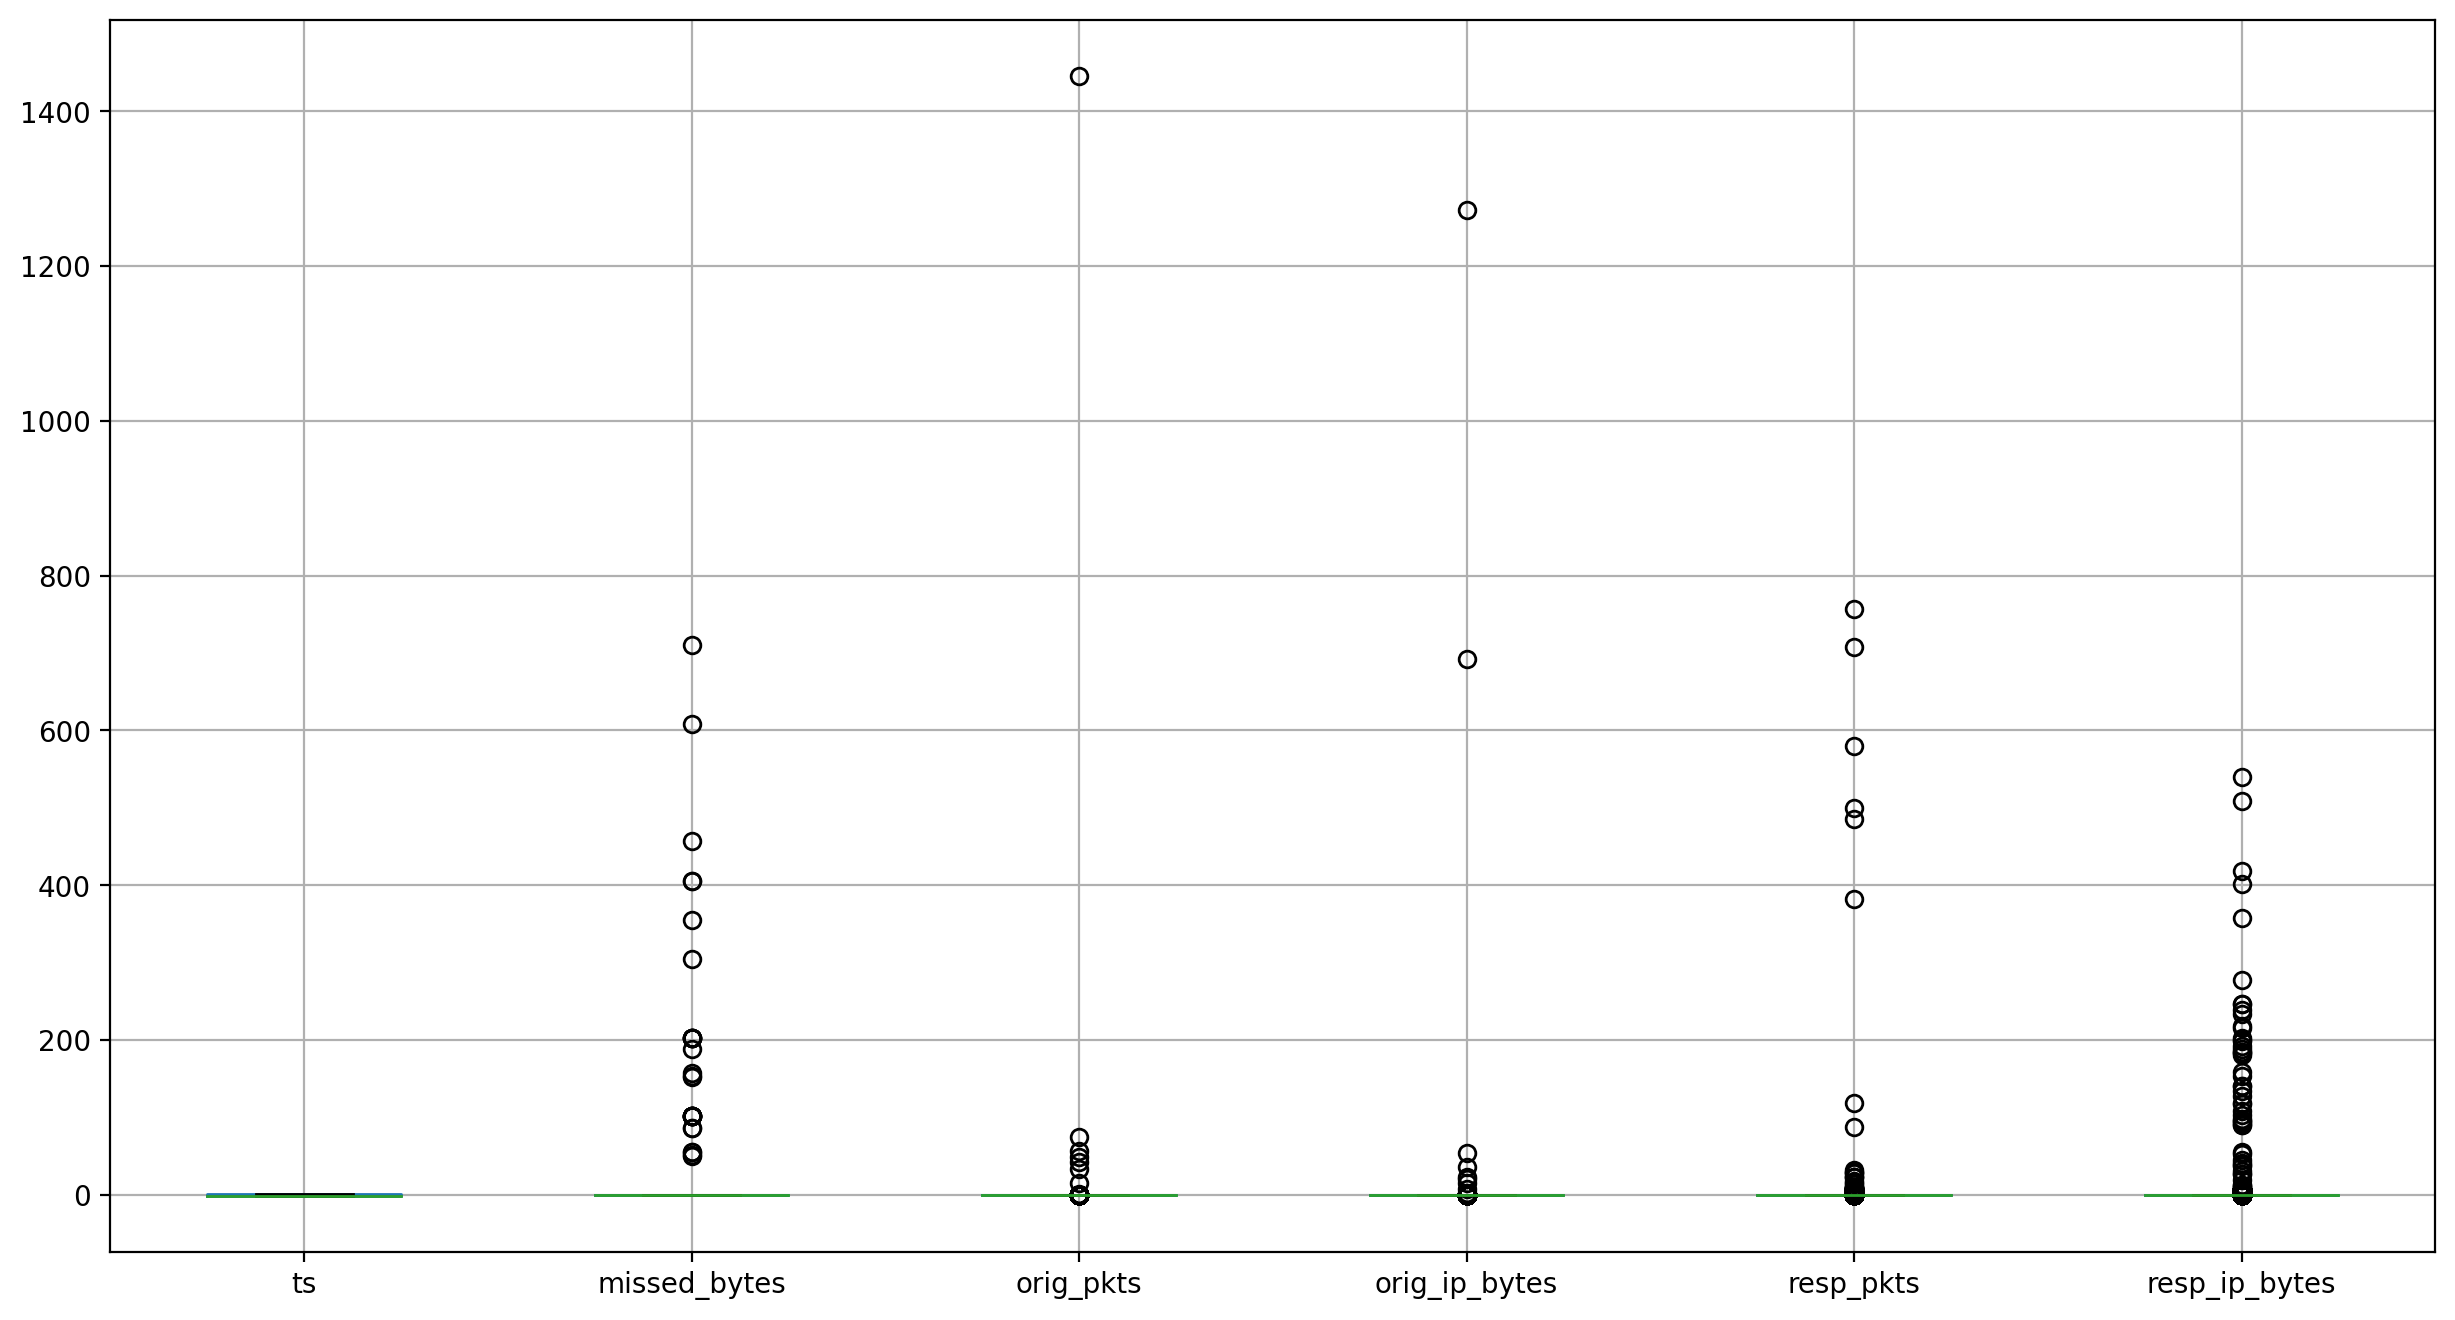

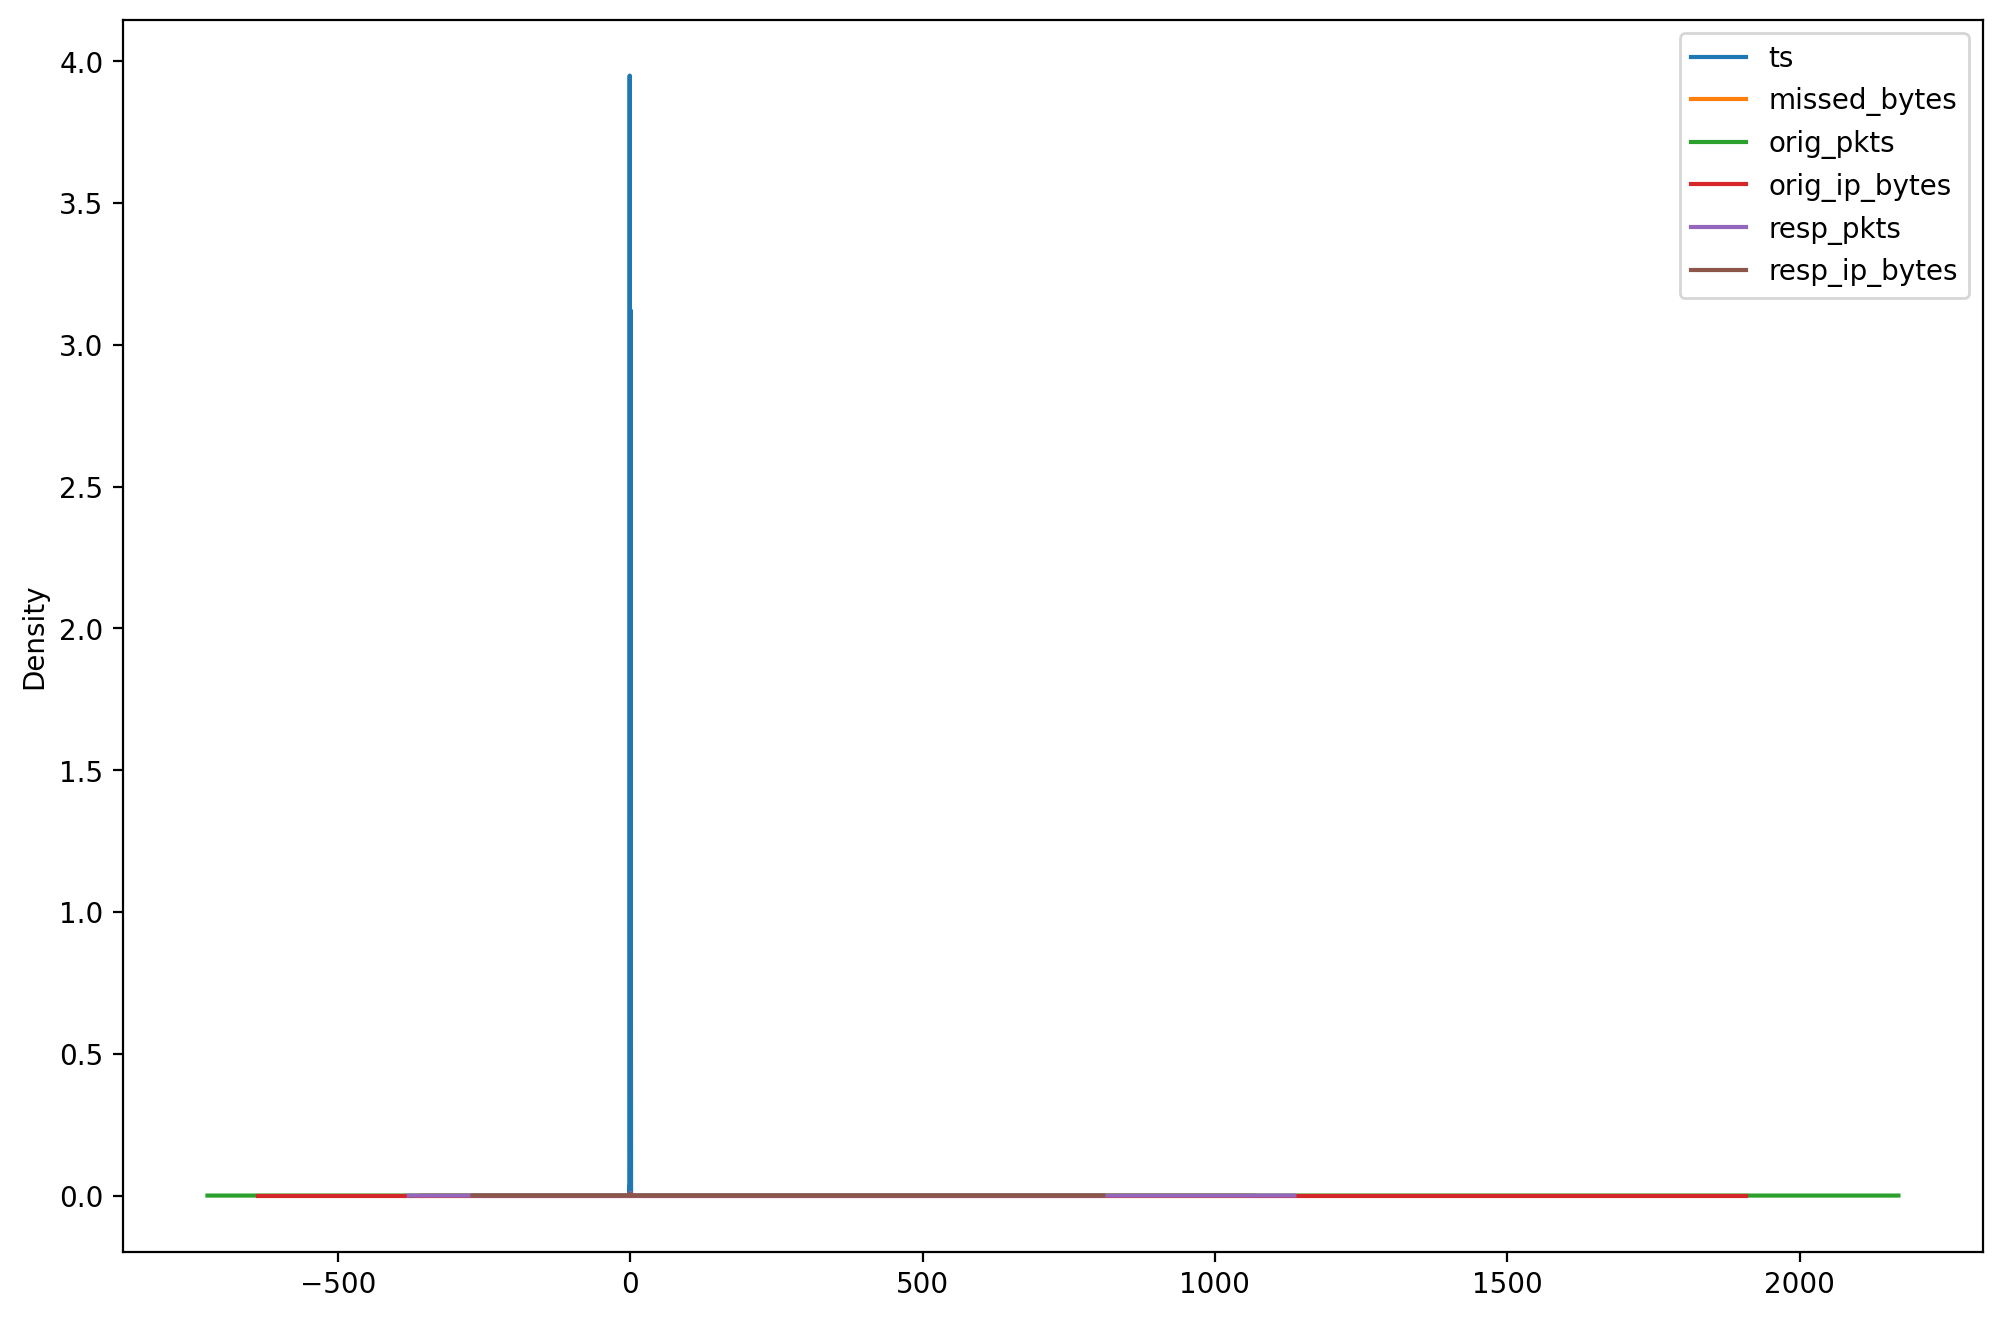

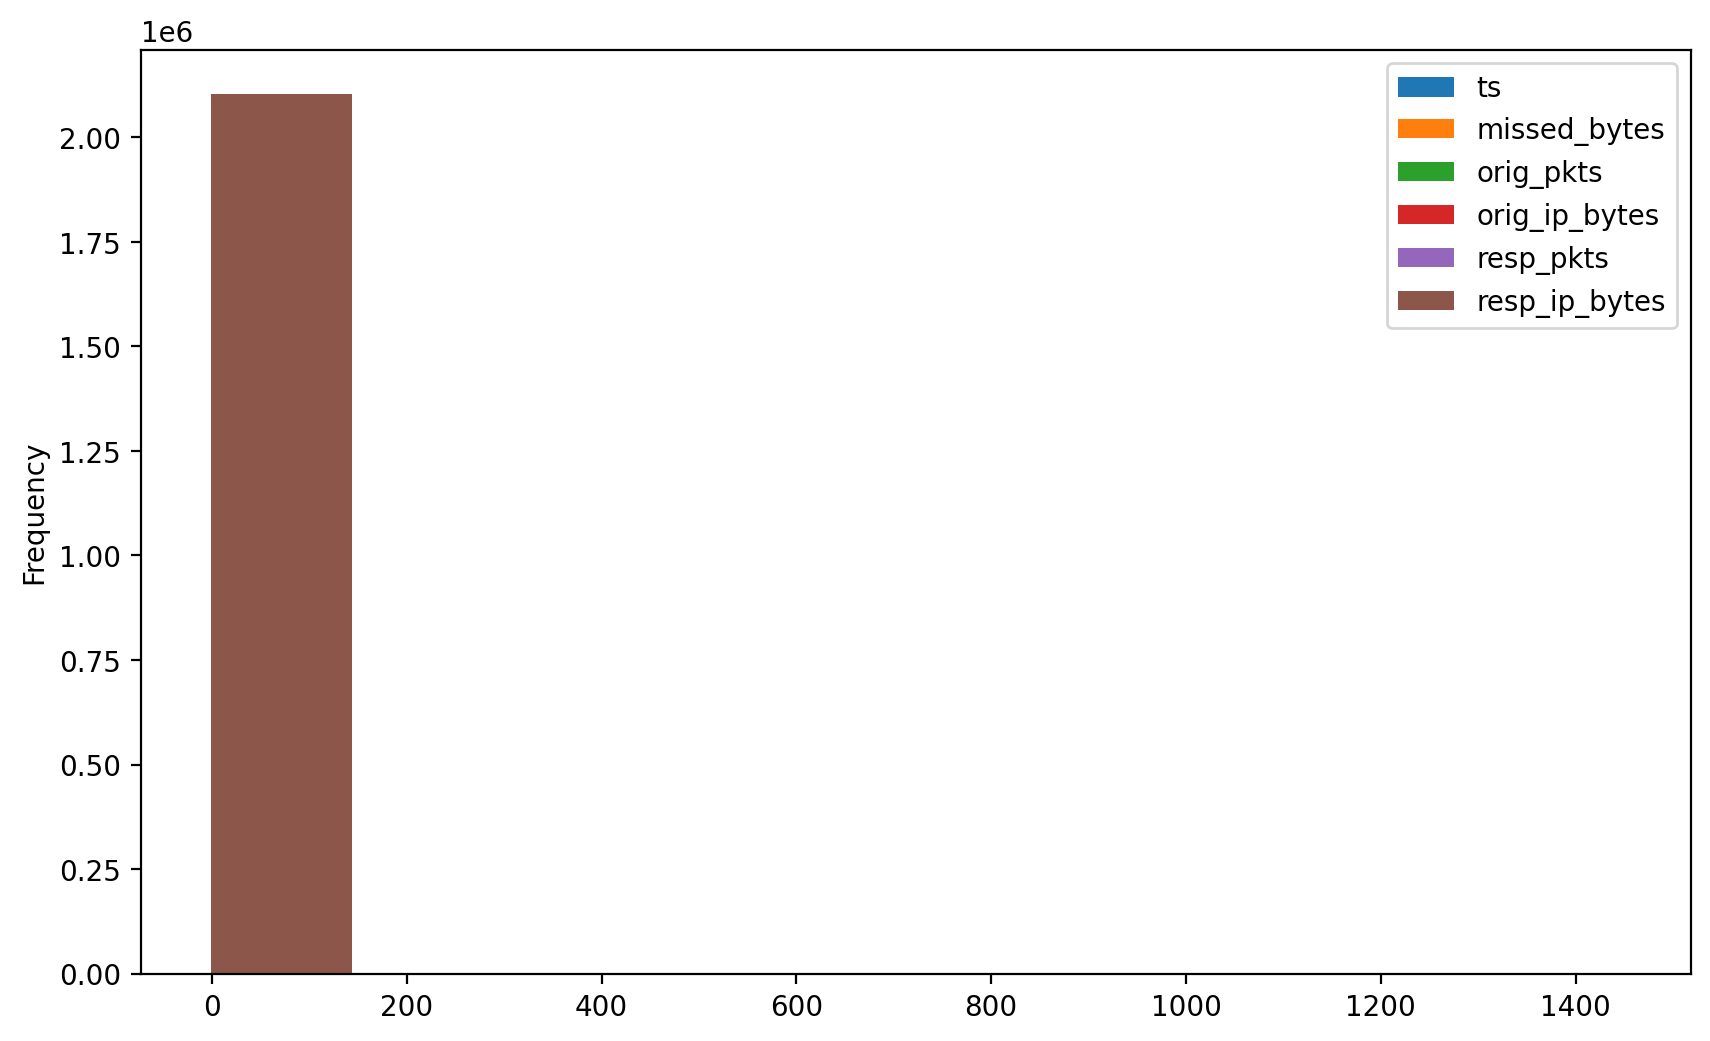

                     ts  missed_bytes  ...  resp_pkts  resp_ip_bytes
ts             1.000000      0.000161  ...  -0.008756      -0.014808
missed_bytes   0.000161      1.000000  ...   0.180467       0.624861
orig_pkts      0.000877      0.000089  ...   0.000467       0.000344
orig_ip_bytes  0.000473      0.000064  ...   0.000329       0.000245
resp_pkts     -0.008756      0.180467  ...   1.000000       0.764122
resp_ip_bytes -0.014808      0.624861  ...   0.764122       1.000000

[6 rows x 6 columns]


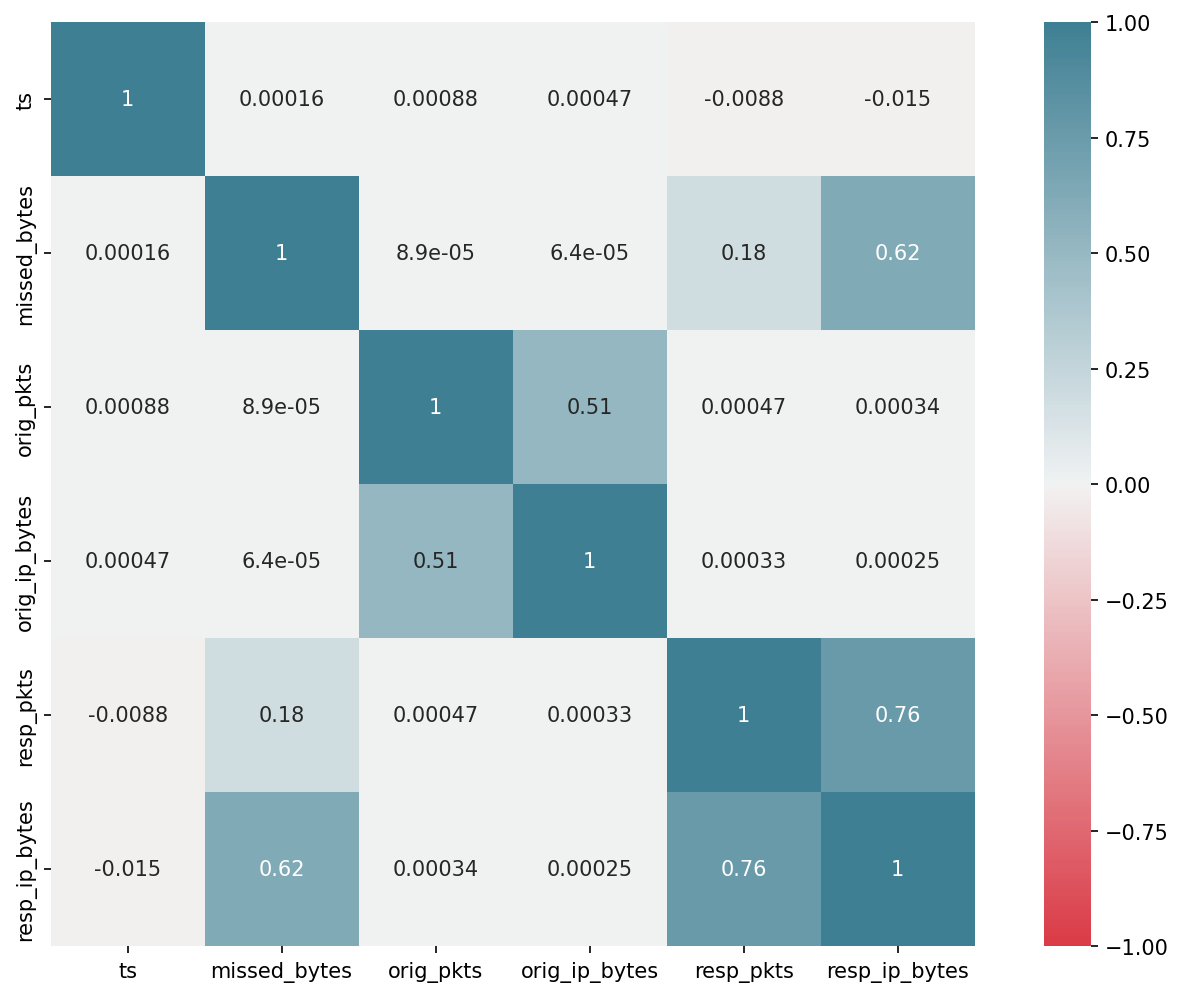

In [ ]:
# Then instantiate:
eda_df = AnalisisDatosExploratorio(df=df)

eda_df.analisis()

Preparacion de datos, codificacion de variables categoricas, seleccion de variables y objetivo y division de datos en entrenamiento y prueba

In [ ]:
df_sample = df.sample(fraction=100000/4790585, seed=42)

In [ ]:
#from pyspark.sql.functions import col
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
import matplotlib.pyplot as plt
import seaborn as sns

# Convertir a pandas DataFrame para el modelado con scikit-learn
final_df = df_sample.toPandas()

# Codificar las variables categóricas (label y detailed-label)
label_encoder = LabelEncoder()
final_df['label_encoded'] = label_encoder.fit_transform(final_df['label'])
#final_df['detailed_label_encoded'] = LabelEncoder().fit_transform(final_df['detailed-label'])

# Seleccionar características y variable objetivo
# Usaremos las 6 características numéricas identificadas en el EDA
features = ['ts', 'missed_bytes', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes']
X = final_df[features]
y = final_df['label_encoded']  # Podrías usar también 'detailed_label_encoded' para más granularidad

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Verificar distribución de clases
print("Distribución de clases en y_train:", np.unique(y_train, return_counts=True))
print("Distribución de clases en y_test:", np.unique(y_test, return_counts=True))

Distribución de clases en y_train: (array([0, 1]), array([ 7059, 23683]))
Distribución de clases en y_test: (array([0, 1]), array([ 3025, 10151]))


Definición de Métricas de Evaluación

In [ ]:
from sklearn.metrics import roc_auc_score
import numpy as np

def evaluate_model(model, X_test, y_test, label_encoder=None):
    y_pred = model.predict(X_test)
    
    # Obtener nombres de clases como strings
    if label_encoder is not None:
        target_names = [str(cls) for cls in label_encoder.classes_]
    else:
        target_names = [str(cls) for cls in np.unique(y_test)]
    
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=target_names))
    
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=target_names, 
                yticklabels=target_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='weighted'),
        'recall': recall_score(y_test, y_pred, average='weighted'),
        'f1': f1_score(y_test, y_pred, average='weighted')
    }
    
    # Manejo de predict_proba solo si es aplicable
    if hasattr(model, "predict_proba"):
        try:
            y_proba = model.predict_proba(X_test)
            if len(target_names) == 2:  # Binario
                metrics['roc_auc'] = roc_auc_score(y_test, y_proba[:, 1])
            else:  # Multiclase
                metrics['roc_auc'] = roc_auc_score(
                    y_test, 
                    y_proba, 
                    multi_class='ovr',
                    average='weighted'
                )
        except Exception as e:
            print(f"Advertencia: No se pudo calcular ROC AUC. Error: {str(e)}")
            metrics['roc_auc'] = None
    
    return metrics

Modelo 1: Random Forest con Manejo de Desbalanceo

Nuevo mejor modelo: 0.9758 con params: 100, None, 2
Nuevo mejor modelo: 0.9769 con params: 100, None, 5
Nuevo mejor modelo: 0.9833 con params: 100, 10, 2
Nuevo mejor modelo: 0.9833 con params: 100, 20, 5
Nuevo mejor modelo: 0.9833 con params: 200, 20, 5
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.91      0.95      3025
           1       0.97      1.00      0.99     10151

    accuracy                           0.98     13176
   macro avg       0.98      0.95      0.97     13176
weighted avg       0.98      0.98      0.98     13176


Confusion Matrix:


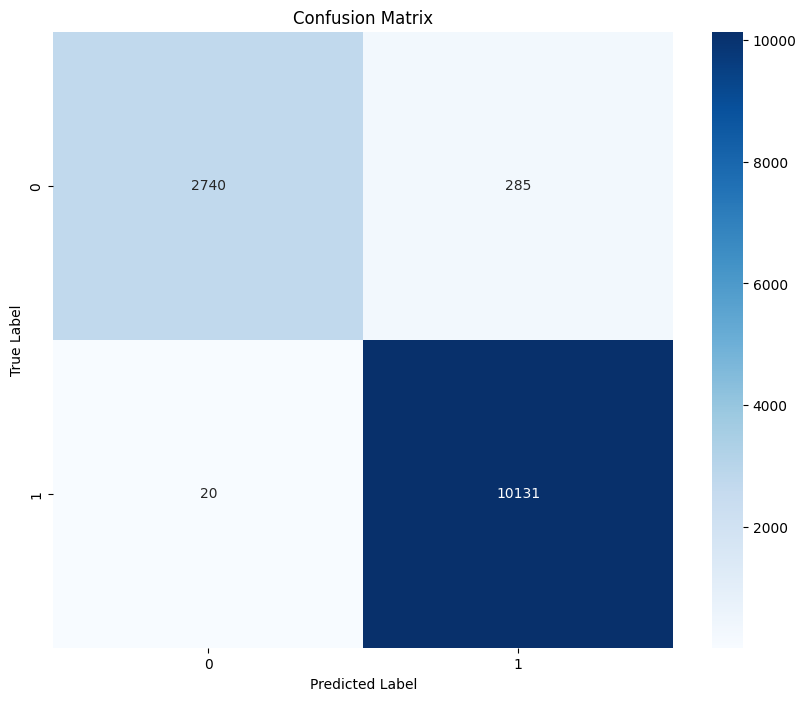

{'accuracy': 0.9768518518518519,
 'precision': 0.9772564188069389,
 'recall': 0.9768518518518519,
 'f1': 0.9764707939094692,
 'roc_auc': 0.9815811982860461}

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from dask.distributed import Client
from sklearn.utils import parallel_backend
from sklearn.base import clone
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import StratifiedKFold

# Versión modificada del primer modelo
def train_rf_with_smote(X_train, y_train, param_grid):
    best_score = -1
    best_model = None
    
    for n_estimators in param_grid['rf__n_estimators']:
        for max_depth in param_grid['rf__max_depth']:
            for min_samples_split in param_grid['rf__min_samples_split']:
                # Usar RandomOverSampler para clases con menos de 6 muestras
                min_samples = min(np.bincount(y_train))
                if min_samples < 6:
                    sampler = RandomOverSampler(random_state=42)
                else:
                    sampler = SMOTE(random_state=42, k_neighbors=5)
                
                X_res, y_res = sampler.fit_resample(X_train, y_train)
                
                # Entrenar modelo
                model = RandomForestClassifier(
                    random_state=42,
                    class_weight='balanced',
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    min_samples_split=min_samples_split
                )
                model.fit(X_res, y_res)
                
                # Validación cruzada manual (3-fold)
                scores = []
                for train_idx, val_idx in StratifiedKFold(n_splits=3).split(X_res, y_res):
                    X_tr, X_val = X_res.iloc[train_idx], X_res.iloc[val_idx]
                    y_tr, y_val = y_res.iloc[train_idx], y_res.iloc[val_idx]
                    
                    m = clone(model)
                    m.fit(X_tr, y_tr)
                    scores.append(f1_score(y_val, m.predict(X_val), average='weighted'))
                
                mean_score = np.mean(scores)
                if mean_score > best_score:
                    best_score = mean_score
                    best_model = model
                    print(f"Nuevo mejor modelo: {mean_score:.4f} con params: {n_estimators}, {max_depth}, {min_samples_split}")
    
    return best_model

# Parámetros
param_grid = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [None, 10, 20],
    'rf__min_samples_split': [2, 5]
}

# Entrenar
best_rf = train_rf_with_smote(X_train, y_train, param_grid)

# Evaluar
rf_metrics = evaluate_model(best_rf, X_test, y_test)

Modelo 2: XGBoost con Peso de Clases

/local_disk0/.ephemeral_nfs/envs/pythonEnv-838435d7-ddb9-403b-bb91-75fa2378ce8e/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [00:44:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      3025
           1       0.97      1.00      0.99     10151

    accuracy                           0.98     13176
   macro avg       0.99      0.95      0.97     13176
weighted avg       0.98      0.98      0.98     13176


Confusion Matrix:


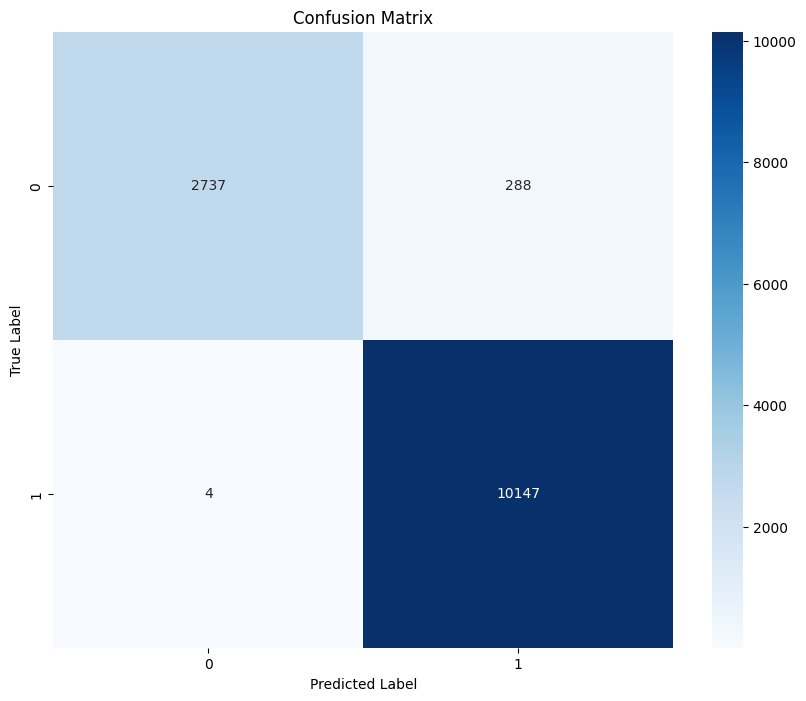

Métricas XGBoost: {'accuracy': 0.9778384942319368, 'precision': 0.9784019269445499, 'recall': 0.9778384942319368, 'f1': 0.9774455877380409, 'roc_auc': 0.9826129249978222}


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
import numpy as np


def train_xgboost_simple(X_train, y_train):
    # Calcular scale_pos_weight (para clase 1 vs. clase 0)
    scale_pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1)
    
    # Parámetros base
    params = {
        'n_estimators': 100,
        'max_depth': 6,
        'learning_rate': 0.1,
        'random_state': 42,
        'scale_pos_weight': scale_pos_weight,  
        'eval_metric': 'mlogloss',
        'use_label_encoder': False
    }
    
    model = XGBClassifier(**params)
    model.fit(X_train, y_train)
    return model

# Entrenar modelo simple
xgb_model = train_xgboost_simple(X_train, y_train)

# Evaluación
xgb_metrics = evaluate_model(xgb_model, X_test, y_test)
print("Métricas XGBoost:", xgb_metrics)

Modelo 3: Regresión Logística con SMOTE

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3025
           1       0.77      1.00      0.87     10151

    accuracy                           0.77     13176
   macro avg       0.39      0.50      0.44     13176
weighted avg       0.59      0.77      0.67     13176


Confusion Matrix:


/local_disk0/.ephemeral_nfs/envs/pythonEnv-838435d7-ddb9-403b-bb91-75fa2378ce8e/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/local_disk0/.ephemeral_nfs/envs/pythonEnv-838435d7-ddb9-403b-bb91-75fa2378ce8e/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/local_disk0/.ephemeral_nfs/envs/pythonEnv-838435d7-ddb9-403b-bb91-75fa2378ce8e/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in label

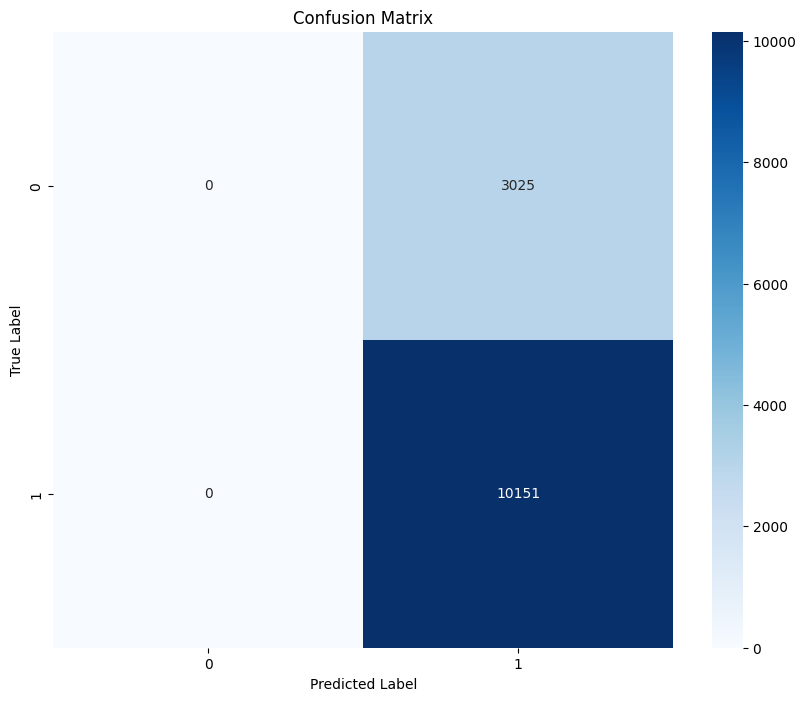

/local_disk0/.ephemeral_nfs/envs/pythonEnv-838435d7-ddb9-403b-bb91-75fa2378ce8e/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Métricas Regresión Logística Simple: {'accuracy': 0.7704159077109897, 'precision': 0.5935406708541481, 'recall': 0.7704159077109897, 'f1': 0.670509870894179, 'roc_auc': 0.8210930649669332}


In [ ]:
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import numpy as np

def train_logistic_with_smote(X_train, y_train):
    # Calcular k_neighbors seguro
    min_samples = min(np.bincount(y_train))
    k_neighbors = min(5, min_samples - 1)
    
    # Asegurarnos que k_neighbors sea al menos 1
    k_neighbors = max(1, k_neighbors)
    
    # Aplicar SMOTE con parámetros seguros
    sm = SMOTE(random_state=42, k_neighbors=k_neighbors)
    X_res, y_res = sm.fit_resample(X_train, y_train)
    
  
    params = {
        'C': 1.0,               # Parámetro de regularización
        'penalty': 'l2',        # Regularización L2 (Ridge)
        'solver': 'liblinear',  # Buen solver para problemas pequeños/medianos
        'random_state': 42,
        'max_iter': 1000,       # Número suficiente de iteraciones
        'class_weight': 'balanced'  # Manejo automático de clases desbalanceadas
    }
    
    # Entrenar modelo base
    model = LogisticRegression(**params)
    model.fit(X_res, y_res)
    
    return model

# Entrenar modelo simple
lr_model = train_logistic_with_smote(X_train, y_train)

# Evaluación
lr_metrics = evaluate_model(lr_model, X_test, y_test)
print("Métricas Regresión Logística Simple:", lr_metrics)

Comparación de Modelos

<Figure size 1200x600 with 0 Axes>

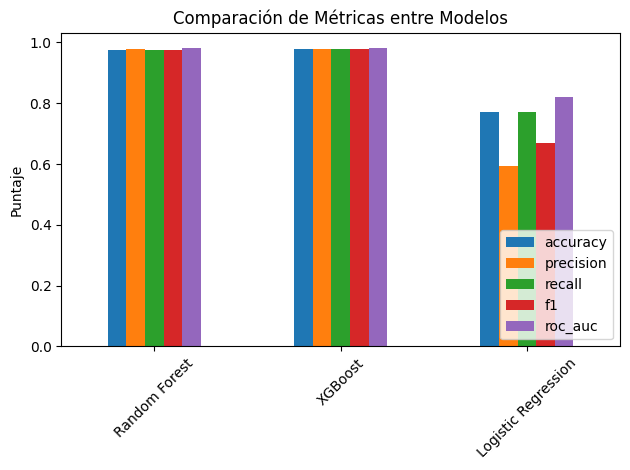


Resumen de Métricas:
                     accuracy  precision    recall        f1   roc_auc
Random Forest        0.976852   0.977256  0.976852  0.976471  0.981581
XGBoost              0.977838   0.978402  0.977838  0.977446  0.982613
Logistic Regression  0.770416   0.593541  0.770416  0.670510  0.821093


In [ ]:
# Crear DataFrame con las métricas de los modelos
metrics_df = pd.DataFrame({
    'Random Forest': rf_metrics,
    'XGBoost': xgb_metrics,
    'Logistic Regression': lr_metrics
}).T

# Visualización comparativa
plt.figure(figsize=(12, 6))
metrics_df.plot(kind='bar', rot=45)
plt.title('Comparación de Métricas entre Modelos')
plt.ylabel('Puntaje')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

print("\nResumen de Métricas:")
print(metrics_df)

Análisis de Resultados y Recomendaciones

In [ ]:
# Identificar el mejor modelo según F1-score (que considera tanto precisión como recall)
best_model_name = metrics_df['f1'].idxmax()
best_model = {
    'Random Forest': best_rf,
    'XGBoost': xgb_model,
    'Logistic Regression': lr_model
}[best_model_name]

print(f"\nEl mejor modelo es: {best_model_name} con un F1-score de {metrics_df.loc[best_model_name, 'f1']:.4f}")

# Posibles mejoras:
print("\nRecomendaciones para mejorar los modelos:")
print("1. El dataset original esta conformado por 5 etiquetas de salida, sin embargo la granularidad era muy alta y desbalanceada, 3 de las clases tenian muy pocos registros, por lo que la mejor metodologia fue reducir el dataset a solo dos etiquetas, 'Malicious' y 'Benign' ")
print("2. Se entrenaron modelos diferentes con dos cantidades de datos, una con cerca de dos millones de registros y una segunda version con solo 100 mil registros, por lo que se peude concluir que los datos son muy uniformes y claros para el modelo de entrenamiento, es decir la exactitud al momento de clasificar no varia en ambos casos, las metricas son similares, dicho esto se recomienda utilizar una muestra con datos reducidos.")
print("3. Probar arquitecturas más complejas o ensembles de modelos")
print("4. Ajustar los umbrales de decisión para optimizar métricas específicas")


El mejor modelo es: XGBoost con un F1-score de 0.9774

Recomendaciones para mejorar los modelos:
1. El dataset original esta conformado por 5 etiquetas de salida, sin embargo la granularidad era muy alta y desbalanceada, 3 de las clases tenian muy pocos registros, por lo que la mejor metodologia fue reducir el dataset a solo dos etiquetas, 'Malicious' y 'Benign' 
2. Se entrenaron modelos diferentes con dos cantidades de datos, una con cerca de dos millones de registros y una segunda version con solo 100 mil registros, por lo que se peude concluir que los datos son muy uniformes y claros para el modelo de entrenamiento, es decir la exactitud al momento de clasificar no varia en ambos casos, las metricas son similares, dicho esto se recomienda utilizar una muestra con datos reducidos.
3. Probar arquitecturas más complejas o ensembles de modelos
4. Ajustar los umbrales de decisión para optimizar métricas específicas


In [ ]:
import joblib

# Guardar el mejor modelo
joblib.dump(best_model, 'mejor_modelo_malware_detection.pkl')

# Guardar el label encoder para uso futuro
joblib.dump(label_encoder, 'label_encoder.pkl')

print("Modelo y preprocesadores guardados correctamente.")

Modelo y preprocesadores guardados correctamente.


Guardar el Mejor Modelo